### Segment blood smear and count different celltypes based on image processing and OpenCV

In [1]:
# Import libraries
import numpy as np
import cv2
import pandas as pd
import requests

from matplotlib import pyplot as plt

In [2]:
# Define functions

#Function to download file from internet url
def get_image(url):
    local_filename = 'blood.jpg'
    
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    
    img = cv2.imread(local_filename)
    #img = cv2.GaussianBlur(img, (5, 5), 0)
    
    return img

# Function to draw a rectangle around the set points and annotate
def smear(xmin,ymin,xmax,ymax,img,ctype,color):
    if (xmin<2):
        xmin = 2
    if (ymin<2):
        ymin = 2

    tmp = np.ones([(ymax-ymin), 2, 3]) * 0
    img[ymin:ymax, (xmin-2):xmin, 0:3] = tmp
    tmp = np.ones([2,(xmax-xmin),3]) * 0
    img[(ymin-2):ymin, xmin:xmax, 0:3] = tmp
    tmp = np.ones([(ymax-ymin),2,3]) * 0
    img[ymin:ymax, (xmax-2):xmax, 0:3] = tmp
    tmp = np.ones([2,(xmax-xmin),3]) * 0
    img[(ymax-2):ymax, xmin:xmax, 0:3] = tmp

    cv2.putText(img, ctype, (xmin + 10, ymin + 15),
				cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * img.shape[0], color, 2)
    return 

# Plot multiple images
def plt_imgs(imgs, types, title, num_imgs=3):
    fig, axes = plt.subplots(1, num_imgs)
    
    for i in range(num_imgs):
        axes[i].imshow(imgs[i])
        axes[i].set_title('{} {}'.format(types[i], title))
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        
    return

In [3]:
#specify the csv path containing identifiers
csv_path = 'https://raw.githubusercontent.com/Shenggan/BCCD_Dataset/master/test.csv'
#specify root folder for blood images
root = 'https://raw.githubusercontent.com/Shenggan/BCCD_Dataset/master/BCCD/JPEGImages/'
# Read annotations
df = pd.read_csv(csv_path)

In [4]:
# Read the image
blood = "BloodImage_00366.jpg" #"BloodImage_00183.jpg" #"BloodImage_00355.jpg" #"BloodImage_00203.jpg"

rslt_df = df.loc[df['filename'] == blood]
img = get_image(root+blood)

In [5]:
# Set the different thresholds
celltypes = ["WBC", "RBC", "Platelets"]
# Colors to mark annotations
colors = [(0,0,255),(255,0,0),(0,0,0)]

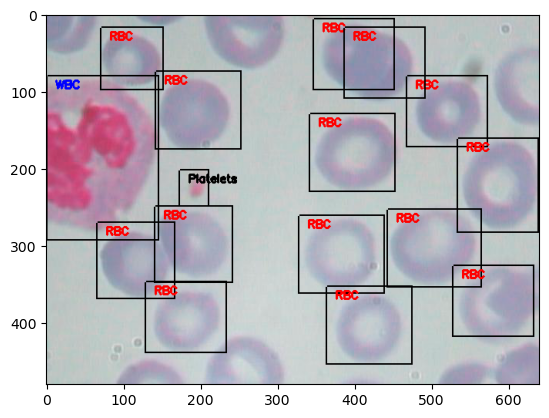

In [6]:
# Plot the annotations
ann_img = img.copy()

for i,name in enumerate(celltypes):
    rslt_df1 = rslt_df.loc[rslt_df['cell_type'] == name]

    for j, ind in enumerate(rslt_df1.index):
        xmin = int(rslt_df1["xmin"][ind])
        xmax = int(rslt_df1["xmax"][ind])
        ymin = int(rslt_df1["ymin"][ind])
        ymax = int(rslt_df1["ymax"][ind])
        smear(xmin,ymin,xmax,ymax,ann_img,ctype=name,color=colors[i])
        
        
plt.imshow(ann_img)

Text(0.5, 1.0, 'HSV image ')

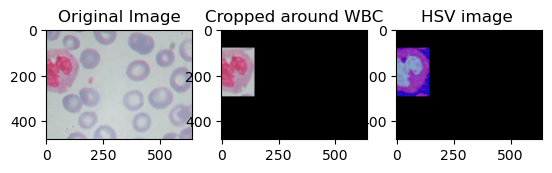

In [7]:
# Crop the image given the coordinates of the cell
def blood_seg_new(xmin, ymin, xmax, ymax, img):
    y, x, c = img.shape
    img[0:ymin, :, :] = np.zeros([ymin, x, 3])
    img[ymax:, :, :] = np.zeros([y-ymax, x, 3])
    img[:, 0:xmin, :] = np.zeros([y, xmin, 3])
    img[:, xmax:, :] = np.zeros([y, x-xmax, 3])
    
    return 
# Crop the image around a single WBC
type = 'WBC'
rslt_df1 = rslt_df.loc[rslt_df['cell_type'] == type]

crp_img = img.copy()

ind = rslt_df1.index[0]
xmin = int(rslt_df1["xmin"][ind])
xmax = int(rslt_df1["xmax"][ind])
ymin = int(rslt_df1["ymin"][ind])
ymax = int(rslt_df1["ymax"][ind])

blood_seg_new(xmin, ymin, xmax, ymax, crp_img)

hsv_img = cv2.cvtColor(crp_img, cv2.COLOR_BGR2HSV)

fig, axes = plt.subplots(1, 3)
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[1].imshow(crp_img)
axes[1].set_title('Cropped around ' + type)
axes[2].imshow(hsv_img)
axes[2].set_title('HSV image ')

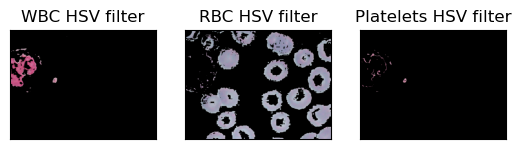

In [8]:
# HSV thresholds
wbc_th = [np.array([120, 30, 180]), np.array([135, 160, 225])]
plt_th = [np.array([110, 55, 180]), np.array([135, 110, 210])]
rbc_th = [np.array([0, 20, 170]), np.array([20, 55, 220]), np.array([150, 20, 170]), np.array([179, 55, 220])]
                                           
ths = [wbc_th, rbc_th, plt_th]

# Apply HSV thresholding
def hsv_filter(img, hsv, threshold):
    # Threshold into a range.
    mask = cv2.inRange(hsv, threshold[0], threshold[1])
    
    if len(threshold) > 2:
        # Used with Red color 
        mask2 = cv2.inRange(hsv, threshold[2], threshold[3])
        mask = mask + mask2
        
    output = cv2.bitwise_and(img,img, mask= mask)
    
    return output

# Apply color filtering on the image 
filt_imgs = []

hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
for i, cell in enumerate(celltypes):
    filt_op = hsv_filter(img, hsv_img, ths[i])
    
    filt_imgs.append(filt_op)
    
plt_imgs(filt_imgs, celltypes, 'HSV filter')

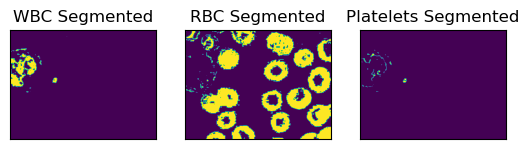

In [9]:
# Apply Otsu's binary thresholding
# Adapted from https://learnopencv.com/otsu-thresholding-with-opencv/
def otsu_th(img):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_img)
    
    # Applying Otsu's method setting the flag value into cv.THRESH_OTSU.
    # Use a bimodal image as an input.
    # Optimal threshold value is cdetermined automatically.
    otsu_th, image_result = cv2.threshold(
        v, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
    )
    
    return image_result

# Apply the otsu's filter on the color image
def apply_otsu(hsv_img, image_result):
    h, s, v = cv2.split(hsv_img)
    v1 = image_result
    hsv_image = cv2.merge([h, s, v1])

    out = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    
    return out

# Apply image segmentation
seg_imgs = []

for i, cell in enumerate(celltypes):
    seg_op = otsu_th(filt_imgs[i])
    #seg_op = apply_otsu(hsv_img, seg_op)
    
    seg_imgs.append(seg_op)
    
plt_imgs(seg_imgs, celltypes, 'Segmented')

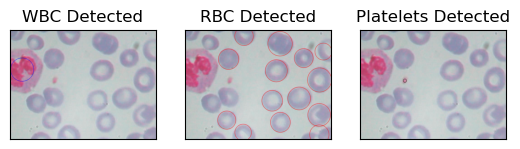

In [10]:
# Area thresholds
areas = [[4000, 60000], [2500, 10000], [150, 300]]

# Blob detection
# https://stackoverflow.com/questions/65026468/cv2-simpleblobdetector-difficulties for explanation
def detect_blobs(img, area):
    params = cv2.SimpleBlobDetector_Params() 

    params.filterByColor = False
    params.blobColor = 0 

    params.minThreshold = 0 
    params.maxThreshold = 255.0 
    params.thresholdStep = 5 
    params.minDistBetweenBlobs = 3.0 
    params.minRepeatability = 2 
    
    # Filter by Circularity
    params.filterByCircularity = False
    params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = False
    params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = False
    params.minInertiaRatio = 0.3

    # Filter by Area.
    params.filterByArea = True
    params.minArea = area[0]
    params.maxArea = area[1]
    
    detector = cv2.SimpleBlobDetector_create(params)

    #keypoints = detector.detect(cv2.bitwise_not(img))
    keypoints = detector.detect(img)
    
    return keypoints

# Plot circles around the image
def plot_keypt(img, keypts, color, text = None):
    op_img = cv2.drawKeypoints(img, keypts, np.array([]), color, cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    if text is not None:
        for keypt in keypts:
            cv2.putText(op_img, text, (int(keypt.pt[0]), int(keypt.pt[1])),
                        cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * img.shape[0], color, 2)
            #cv2.putText(op_img, text, (10, 10),
            #            cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * img.shape[0], color, 2)

    return op_img


# Apply blob detection

blob_imgs = []
all_keypts = []

for i, cell in enumerate(celltypes):
    keypts = detect_blobs(seg_imgs[i], areas[i])
    
    blob_op = plot_keypt(img, keypts, colors[i])
    
    blob_imgs.append(blob_op)
    
    if cell == 'WBC':
        for keypt in keypts:
            x = int(keypt.pt[0])
            y = int(keypt.pt[1])
            size = int(keypt.size)
            seg_imgs[2] = cv2.circle(seg_imgs[2], (x, y), size, (0, 0, 0), cv2.FILLED, 8, 0)
        
    
    all_keypts.append(keypts)
    
plt_imgs(blob_imgs, celltypes, 'Detected')

1 WBC cells in BloodImage_00366.jpg
Detected 1 WBC cells
14 RBC cells in BloodImage_00366.jpg
Detected 14 RBC cells
1 Platelets cells in BloodImage_00366.jpg
Detected 1 Platelets cells


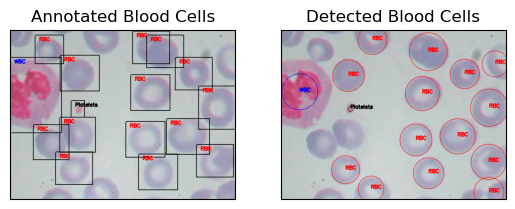

In [11]:
# Plot the annotations
ann_img = img.copy()
det_img = img.copy()

for i,name in enumerate(celltypes):
    rslt_df1 = rslt_df.loc[rslt_df['cell_type'] == name]

    for j, ind in enumerate(rslt_df1.index):
        xmin = int(rslt_df1["xmin"][ind])
        xmax = int(rslt_df1["xmax"][ind])
        ymin = int(rslt_df1["ymin"][ind])
        ymax = int(rslt_df1["ymax"][ind])
        smear(xmin,ymin,xmax,ymax,ann_img,ctype=name,color=colors[i])
        
    print('{} {} cells in {}'.format(j+1, name, blood))
    print('Detected {} {} cells'.format(len(all_keypts[i]), name))
        
    det_img = plot_keypt(det_img, all_keypts[i], colors[i], name)

imgs = [ann_img, det_img]
types = ['Annotated', 'Detected']

plt_imgs(imgs, types, 'Blood Cells', 2)